## Design promotional offers for Starbucks customers

For the capstone project of Udacity's Data Scientist Nanodegree Program, a simulated Starbucks dataset was provided. The dataset not only records promotional offers being sent to Starbucks customers, but also records customers' reactions to the offers, their demographic information, and transaction history.

With this rich dataset, many questions can be formed and answered. <span style="color:dodgerblue">***Here I focused on one single question: How can we learn from this dataset to effectively design and promote offers?***</span> Specifically, I answered this question in three scenarios:
1. [Knowing nothing about the customer](#first-bullet)
2. [Knowing demographic information of the customer](#second-bullet)
3. [Knowing both demographic information and transaction history of the customer](#third-bullet)


In [1]:
import pandas as pd
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [98]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

## 0. Load preprocessed data from pickle file
* `portfolio` - offer information
* `profile` - customer demographic information
* `transactions` - customer transactional information
* `offers` - reception/view/completion of each offer by customers

Refer to `data_cleaning_n_preprocessing.ipynb` for details of each dataframe

In [129]:
with open("data/processed_data.pickle", "rb") as f:
    portfolio, profile, transactions, offers = pickle.load(f)

## 1. Design offers knowing nothing about the customer<a class="anchor" id="first-bullet"></a>
If we know nothing about the customer, it is a cold start problem. I solved this problem with **a rank-based approach**. 

First, I ranked existing offers by their `view_rate` (the propotion of offers being viewed) and `response_rate` (the propotion of offers being completed after being viewed). Next, I trained two linear regression models to predict the view and response rates based on offer features (offer duration, offer type, etc.). Although the models cannot accurately predict view/response rate with only limited training data, **feature importances** can be derived from the models to evaluate each feature's contribution to view or response rate.

<span style="color:dodgerblue">***For a new customer, one can simply send him/her the highest-ranked offer. Alternatively, one could design a new offer by combining features that boost view or response rate.***</span>.


In [130]:
# calculate the view and respond rate of each offer type
popularity = pd.DataFrame()
popularity['count'] = offers.groupby('offer_id')['offer_id'].count()
popularity['view_rate'] = offers.groupby('offer_id')['viewed'].mean()
popularity['response_rate'] = offers.groupby('offer_id')['responded'].mean()

# merge with offer details for a more insightful look
popularity = pd.merge(popularity, portfolio, how = 'inner', on = 'offer_id')

# encode offer_type for regression
popularity = pd.concat([popularity, pd.get_dummies(popularity['offer_type'], prefix = 'type')], axis = 1)\
                    .drop('offer_type', axis = 1)

popularity

,offer_id,count,view_rate,response_rate,reward,difficulty,duration,channel_web,channel_email,channel_mobile,channel_social,discount_ratio,type_bogo,type_discount,type_informational
0,0,7658,0.876991,0.343301,10,10,7,0,1,1,1,0.500000,1,0,0
1,1,7593,0.961148,0.367180,10,10,5,1,1,1,1,0.500000,1,0,0
2,2,7617,0.544046,0.000000,0,0,4,1,1,1,0,0.000000,0,0,1
3,3,7677,0.543311,0.276801,5,5,7,1,1,1,0,0.500000,1,0,0
4,4,7668,0.347287,0.170970,5,20,10,1,1,0,0,0.250000,0,1,0
5,5,7646,0.959587,0.574418,3,7,7,1,1,1,1,0.428571,0,1,0
6,6,7597,0.964460,0.613927,2,10,10,1,1,1,1,0.200000,0,1,0
7,7,7618,0.877789,0.000000,0,0,3,0,1,1,1,0.000000,0,0,1
8,8,7571,0.959451,0.470083,5,5,5,1,1,1,1,0.500000,1,0,0
9,9,7632,0.539570,0.276599,2,10,7,1,1,1,0,0.200000,0,1,0


The results above shows that although all 10 offers were sent out around 7600 times, their `response_rate` ranged from 0.17 to 0.61, and their `view_rate` ranged from 0.35 to 0.96. **Offer #8, #6, and #7 are the most popular offers** among BOGO offers, discount offers, and information offers, respectively

Below I trained two regression models for `response_rate` and `view_rate` separately. The first model provided insight into designing BOGO and discount offers (spending required), while the second one helped design informational offers (no spending required). 

channel_social       0.251
channel_web          0.081
type_discount        0.036
duration             0.029
channel_mobile       0.013
discount_ratio       0.001
channel_email        -0.000
reward               -0.004
difficulty           -0.017
type_bogo            -0.036


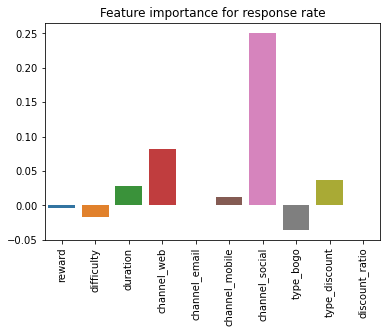

In [131]:
# model 1 - regression model for response_rate
features = ['reward', 'difficulty', 'duration', 'channel_web', 'channel_email', 'channel_mobile',\
       'channel_social', 'type_bogo', 'type_discount', 'discount_ratio']
X = popularity[popularity['type_informational']==0][features]
y = popularity[popularity['type_informational']==0]['response_rate']

model = LinearRegression()
model.fit(X,y)
feature_importances = model.coef_

for feature,importance in sorted(zip(features,feature_importances), key = lambda x:x[1], reverse=True):
    print('{: <20} {:.3f}'.format(feature, importance))
    
sns.barplot(x = features, y = feature_importances)
plt.xticks(rotation=90)
plt.title('Feature importance for response rate');

channel_social       0.419
channel_mobile       0.196
channel_web          0.083
duration             0.000
channel_email        -0.000


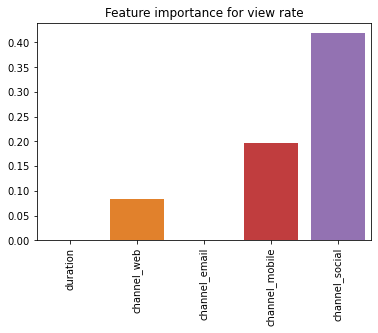

In [132]:
# model 2 - regression model for view_rate
features = ['duration', 'channel_web', 'channel_email', 'channel_mobile', 'channel_social']
X = popularity[features]
y = popularity['view_rate']

model = LinearRegression()
model.fit(X,y)
feature_importances = model.coef_

for feature,importance in sorted(zip(features,feature_importances), key = lambda x:x[1], reverse=True):
    print('{: <20} {:.3f}'.format(feature, importance))
    
sns.barplot(x = features, y = feature_importances)
plt.xticks(rotation=90)
plt.title('Feature importance for view rate');

The feature importances derived from the first model showed that **promotion channels played the biggest role in response rate**. People responded strongly and positively to offers received via social media and web, and slightly positively to offers received via mobile app. Longer promotion duration and less difficulty (minumum spending requirement) improved response rate, as expected. The reward and its ratio to difficulty, surprisingly, did not seem so important. Between BOGO and discount offers, people preferred the latter.

The feature importances derived from the second model showed that **promotion channels also played the biggest role in view rate**. People were mostly likely to view an offer sent via social media, followed by mobile app and web. The duration of the offer has minimal impact on the view rate. 

<span style="color:dodgerblue">***Based on the above findings, here are my strategies for designing offers for new customers:***</span>
* <span style="color:dodgerblue">Use Offer #8 for BOGO offer, Offer #6 for discount offer, and Offer #7 for information offer.</span>
* <span style="color:dodgerblue">Alternatively, if one wish to design a new offer from scratch, make sure it was promoted via both social media and web channels. Run the promotion for a longer period if possible, and design it as a discount-type offer with low minimum purchase requirement. </span>

## 2. Design offers knowing demographic information of the customer<a class="anchor" id="second-bullet"></a>
If we know the demographic information about the customer (age, gender, etc.), we can do a better job predicting customer's response to an offer.  and further design a new offer that .
First, I trained a probabilistic classifier. For a given offer and a customer's demographic information, the classifier was able to output a probability

## 3. Design offers knowing demographic information & transaction history of the customer<a class="anchor" id="third-bullet"></a>
Some customers make purchases without an offer anyway. It is important to identify those customers and EXCLUDE them from offers. With the transaction history information, we can identify those customers. 